
# 🧠 Brain Tumor Classification using CNN

This notebook demonstrates a complete data science workflow for classifying brain tumors from MRI scans into four categories:

- **Glioma Tumor**
- **Meningioma Tumor**
- **Pituitary Tumor**
- **No Tumor**

We use CNNs with TensorFlow and follow good practices: EDA, preprocessing, model training, evaluation, and visualization.


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


## Load and Explore Dataset

In [4]:

from google.colab import files
import zipfile

uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

dataset_path = "dataset/Brain_Tumor_Dataset"


Saving dataset.zip to dataset.zip


## Exploratory Data Analysis (EDA)

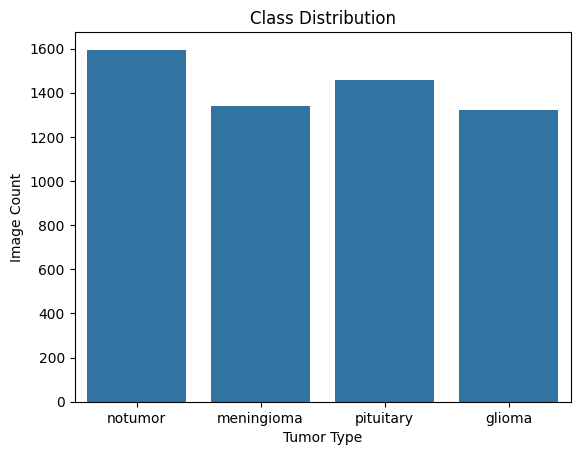

,Tumor Type,Image Count
0,notumor,1595
1,meningioma,1339
2,pituitary,1457
3,glioma,1321


In [8]:
labels = os.listdir(dataset_path)
data = {"Tumor Type": [], "Image Count": []}

for label in labels:
    path = os.path.join(dataset_path, label)
    data["Tumor Type"].append(label)
    data["Image Count"].append(len(os.listdir(path)))

df = pd.DataFrame(data)
sns.barplot(data=df, x="Tumor Type", y="Image Count")
plt.title("Class Distribution")
plt.show()
display(df) # Use display instead of print for better formatting

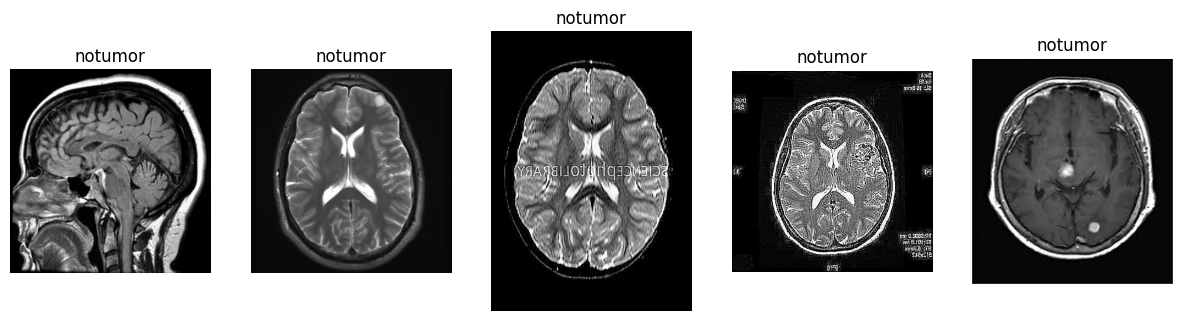

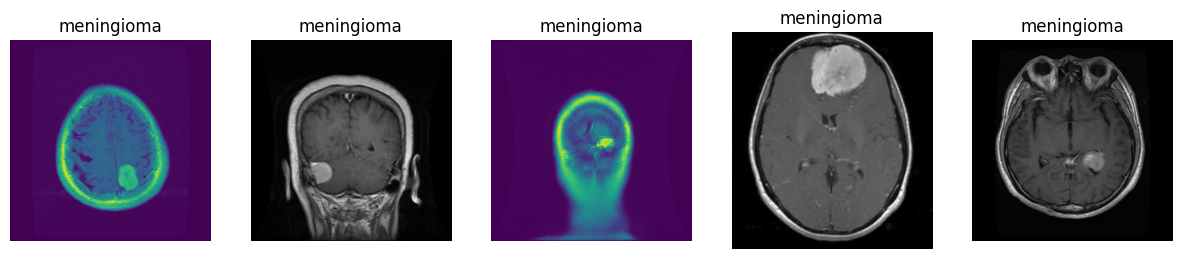

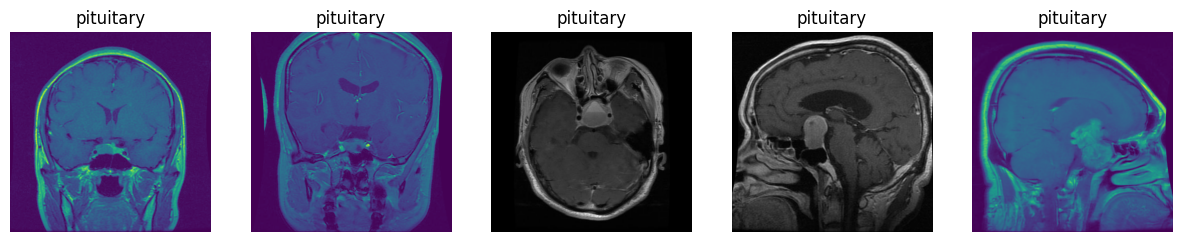

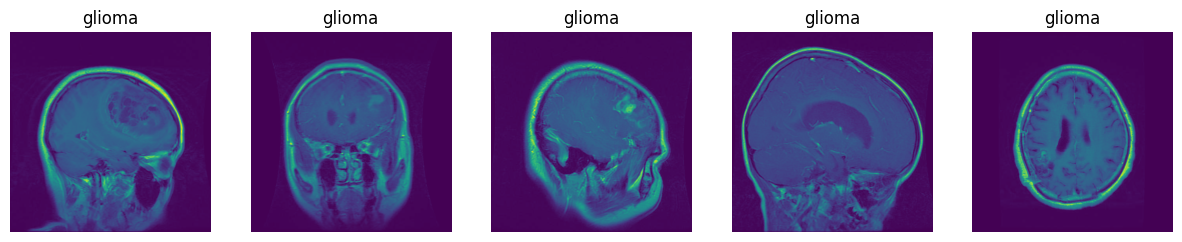

In [9]:

def plot_samples(label, n=5):
    folder = os.path.join(dataset_path, label)
    images = os.listdir(folder)[:n]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(folder, img_name))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.show()

for category in labels:
    plot_samples(category)


## Preprocessing and Augmentation

In [10]:

img_size = 150
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.1,
    fill_mode="nearest"
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


## Build Model

In [11]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,764 (18.42 MB)

 Trainable params: 4,829,316 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

## Train Model

In [12]:

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.5243 - loss: 2.0617 - val_accuracy: 0.2314 - val_loss: 2.6176
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.5910 - loss: 0.9568 - val_accuracy: 0.3672 - val_loss: 1.5188
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.6147 - loss: 0.8779 - val_accuracy: 0.5741 - val_loss: 1.1875
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.6439 - loss: 0.8918 - val_accuracy: 0.6398 - val_loss: 1.2337
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.6763 - loss: 0.7864 - val_accuracy: 0.5925 - val_loss: 1.2520
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.6839 - loss: 0.8228 - val_accuracy: 0.6144 - val_loss: 1.2633
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7065 - loss: 0.7307 - val_accuracy: 0.7301 - val_loss: 1.2829
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7162 - loss: 0.6782 - val_accu

## Save Model

In [13]:

model.save("brain_tumor_model.h5")


## Plot Accuracy and Loss

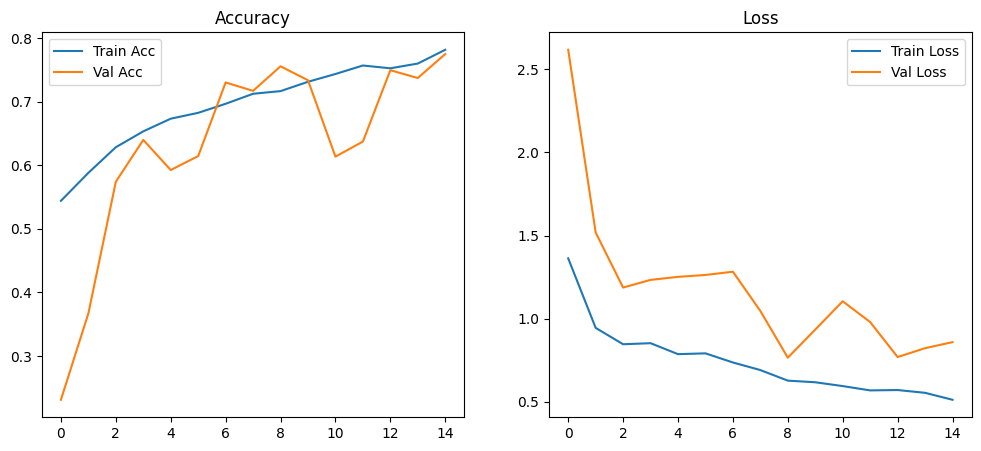

In [14]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


## Evaluation

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 598ms/step


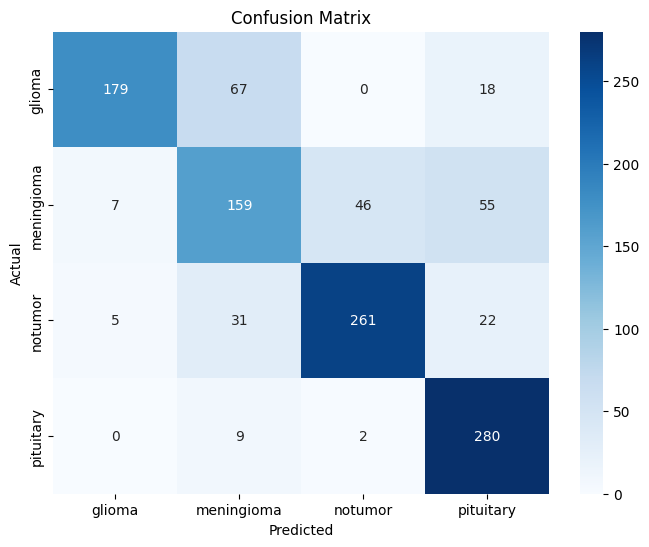

              precision    recall  f1-score   support

      glioma       0.94      0.68      0.79       264
  meningioma       0.60      0.60      0.60       267
     notumor       0.84      0.82      0.83       319
   pituitary       0.75      0.96      0.84       291

    accuracy                           0.77      1141
   macro avg       0.78      0.76      0.76      1141
weighted avg       0.78      0.77      0.77      1141



In [15]:

val_data.reset()
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)
labels = list(val_data.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))
